In [3]:
import numpy as np
import matplotlib.pyplot as plt
from hmlstm import HMLSTMNetwork
import tensorflow as tf
#from text_input_utils import prepare_inputs
import tensorflow as tf
from string import ascii_lowercase

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Regression example

In [66]:
# simulate multiresolution data
num_signals = 200
signal_length = 400
x = np.linspace(0, 200 * np.pi, signal_length)
signals = [np.random.normal(0, .5, size=signal_length) +
           (2 * np.sin(.6 * x + np.random.random() * 100 * np.pi))
           + (5 * np.sin(.1* x + np.random.random() * 100 * np.pi))
           +( 10 * np.sin(.03 * x + np.random.random() * 100 * np.pi))
    for _ in range(num_signals)]

split = int(num_signals * .8)
train = signals[:split]
test = signals[split:]

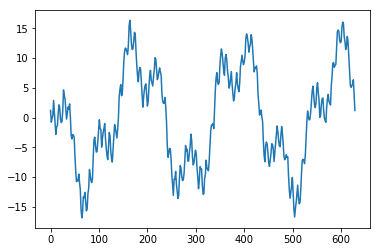

In [67]:
# example signal
plt.plot(x, signals[2]);

In [68]:
# prepare data
train_batches_in = []
train_batches_out = []
batch_size = 10
start = 0
while start + batch_size < len(train):
    batch = train[start: start + batch_size]
    
    train_batches_in.append(np.array([s[:-1] for s in batch]).reshape(batch_size, -1, 1))
    train_batches_out.append(np.array([s[1:] for s in batch]).reshape(batch_size, -1, 1))

    start += batch_size
    
    
batch_size = 1
start = 0
test_batches_in = []
test_batches_out = []
while start + batch_size < len(test):
    batch = test[start: start + batch_size]
    
    test_batches_in.append(np.array([s[:-1] for s in batch]).reshape(batch_size, -1, 1))
    test_batches_out.append(np.array([s[1:] for s in batch]).reshape(batch_size, -1, 1))

    start += batch_size
    
test_batches_in = np.swapaxes(np.array( test_batches_in ), 1, 2)
test_batches_out = np.swapaxes(np.array( test_batches_out ), 1, 2)
train_batches_in = np.swapaxes(np.array( train_batches_in ), 1, 2)
train_batches_out = np.swapaxes(np.array( train_batches_out ), 1, 2)

In [11]:
tf.reset_default_graph()
network = HMLSTMNetwork(input_size=1, task='regression', hidden_state_sizes=20,
                       embed_size=30, out_hidden_size=20, num_layers=3)

In [58]:
network.train(train_batches_in, train_batches_out, epochs=1, load_vars_from_disk=True)

./hmlstm_ckpt
loading variables...
INFO:tensorflow:Restoring parameters from ./hmlstm_ckpt
Epoch 0
loss: 2.32711
loss: 2.51793
loss: 2.75126
loss: 2.39602
loss: 2.31352
loss: 2.62471
loss: 2.32322
loss: 2.90602
loss: 2.63323
loss: 2.66326
loss: 2.49019
loss: 2.39604
loss: 2.46058
loss: 2.25129
loss: 2.48964
saving variables...


In [59]:
batch_num = 2

In [60]:
boundaries = network.predict_boundaries(test_batches_in[batch_num])
print(boundaries[0])

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0. 

In [61]:
# test that indicators are valid
# TODO: figure out why first element is sometimes invalid
b = boundaries[0]
for l in range(1, len(b)):
    for i in range(1, len(b[0])):
        if b[l][i] == 1.:
            if b[l][i - 1] == 0.\
            and b[l - 1][i] == 0. \
            and b[l - 1][i - 1] == 0.:
                print(l, i)
                raise ValueError("Something's not right")

In [62]:
predictions = network.predict(test_batches_in[batch_num])

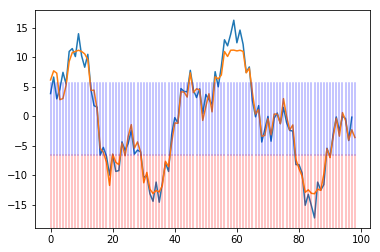

In [63]:
plt.plot(np.array(test_batches_in[batch_num])[:,0][1:])
plt.plot(predictions.flatten())


colors = ['r', 'b', 'g', 'o']
for l, layer in enumerate(boundaries[0]):
    for i, indicator in enumerate(layer):
        if indicator == 1.:
            p = 1 / len(boundaries[0])
            plt.axvline(i, color=colors[l], ymin=(p*l), ymax=(p*(l + 1)), alpha=.3)

In [ ]:
#NOTE: Underpowered networks make more use of boundaries

### Text classificaiton example

In [ ]:
tf.reset_default_graph()
network = HMLSTMNetwork(output_size=29, input_size=29,
                        embed_size=1024, out_hidden_size=500,
                        hidden_state_sizes=200)

In [ ]:
batch_size = 2
truncate_len = 100
num_layers = 3
num_batches = 100

inputs = prepare_inputs(
    batch_size=batch_size, truncate_len=truncate_len, num_batches=num_batches)

In [ ]:
# test on last input\
network.train(inputs[0][:-1], inputs[1][:-1], load_existing_vars=True)

In [ ]:
# predictions on last input
indicators = network.predict_boundaries(inputs[0][-1][0], reuse=True)
indicators

In [ ]:
# predictions on last input
predictions = network.predict(inputs[0][-1][0], reuse=True)

In [ ]:
def get_text(encoding):
    prediction = ''
    
    for char in np.squeeze(encoding):
        max_likelihood = np.where(char == np.max(char))[0][0]
        if max_likelihood < 26:
            prediction += ascii_lowercase[max_likelihood]
        elif max_likelihood == 26:
            prediction += ','
        elif max_likelihood == 27:
            prediction += '.'
        elif max_likelihood == 28:
            prediction += ' '
    
    return prediction

In [ ]:
get_text(predictions)

In [ ]:
get_text(inputs[0][-1][0][1:])